In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import sympy as sym
from scipy import constants as const

In [2]:
data1 = pd.read_csv("tab1.txt", delimiter=' ', index_col="Lp.")
data2 = pd.read_csv("tab2.txt", delimiter=' ', index_col="Lp.")

data1[[1,2,3]] = data1 * 1e-3 #mm -> m
data1 = data1.drop(['D1','D2','D3'], axis = 1)

data2[[1,2,3]] = data2
data2 = data2.drop(['t1','t2','t3'], axis = 1)

m = 1171.7e-3
n = 100

df1 = pd.DataFrame()
#results1.index.name = 'Lp.'
data2

,1,2,3
Lp.,,,
1,68.50,67.92,69.16
2,68.60,68.05,69.25
3,68.41,68.14,69.00
4,68.55,68.02,69.05
5,68.33,68.10,69.12


In [3]:
def calc_uA(series):
    s = 0
    mean = series.mean()
    for x in series:
        s += (x - mean)**2
    s /= len(series)*(len(series)-1)
    return np.sqrt(s)

def calc_uB(Deltas):
    s = 0
    for D in Deltas:
        s += D**2 / 3
    return np.sqrt(s)

def calc_uAB(uA, uB):
    return np.sqrt(uA**2 + uB**2)


Dp_m = 0.1e-3
Dp_D = 0.05e-3
Dp_t = 0.01
De_t = 0.5

un = 1
um = calc_uB([Dp_m])


df1['D'] = data1.mean(axis=0)


df1['uD'] = data1.apply(lambda column: calc_uAB(calc_uA(column), calc_uB([Dp_D])), axis=0)

df1['d'] = df1['D'] / 2


df1['ud'] = df1['uD'] / 2


df1['t'] = data2.mean(axis=0)

df1['ut'] = data2.apply(lambda column: calc_uAB(calc_uA(column), calc_uB([Dp_t, De_t])), axis=0)

df1['T'] = df1['t'] / n


def calc_uC_T(t, n, ut, un):
    return np.sqrt((1/n)**2 * ut**2 + (-t/n**2)**2 * un**2)

df1['uT'] = df1.apply(lambda row : calc_uC_T(row['t'], n, row['ut'], un), axis=1)


def calc_Id(T, m, d):
    return T**2 * m * const.g * d / (4 * const.pi**2)
def calc_uC_Id(T, m, d, uT, um, ud):
    return np.sqrt((2*T * m * const.g * d / (4 * const.pi**2))**2 * uT**2 +
    + (T**2 * const.g * d / (4 * const.pi**2))**2 * um**2 +
    + (T**2 * m * const.g/ (4 * const.pi**2))**2 * ud**2)

df1['Id'] = df1.apply(lambda row : calc_Id(row['T'], m, row['d']), axis=1)
df1['uId'] = df1.apply(lambda row : calc_uC_Id(row['T'], m, row['d'], row['uT'], um, row['ud']), axis=1)


def calc_C(T, d):
    return T**2 * const.g * d - 4 * const.pi**2  * d**2

def calc_uC_C(T, d, uT, ud):
    return np.sqrt((2*T * const.g * d)**2 * uT**2 +
    + (T**2 * const.g - 4 * const.pi**2 * 2*d)**2 * ud**2)
    
df1['C'] = df1.apply(lambda row : calc_C(row['T'], row['d']), axis=1)
df1['uC'] = df1.apply(lambda row: calc_uC_C(row['T'], row['d'], row['uT'], row['ud']), axis=1)


def calc_I0(m, C):
    return m / (4 * const.pi**2) * C

def calc_uC_I0(m, C, um, uC):
    return np.sqrt((1 / (4 * const.pi**2) * C)**2 * um**2 + (m / (4 * const.pi**2) * 1)**2 * uC**2)

df1['I0'] = df1.apply(lambda row: calc_I0(m, row['C']), axis=1)

df1['uI0'] = df1.apply(lambda row: calc_uC_I0(m, row['C'], um, row['uC']), axis=1)


def calc_I0_Steiner(Id, m, d):
    return Id - m * d**2

def calc_uC_I0_Steiner(Id, m, d, uId, um, ud):
    return np.sqrt((1)**2 * uId**2 + (- d**2)**2 * um**2 + (- m *2* d)**2 * ud**2)

df1['I0_S'] = df1.apply(lambda row: calc_I0_Steiner(row['Id'], m, row['d']), axis=1)
df1['uI0_S'] = df1.apply(lambda row: calc_uC_I0_Steiner(row['Id'], m, row['d'], row['uId'], um, row['ud']), axis=1)

df1.T


,1,2,3
D,0.129567,0.119567,0.089467
uD,0.000031,0.000031,0.000031
d,0.064783,0.059783,0.044733
ud,0.000015,0.000015,0.000015
t,68.478000,68.046000,69.116000
ut,0.292781,0.291175,0.291981
T,0.684780,0.680460,0.691160
uT,0.007447,0.007401,0.007503
Id,0.008842,0.008057,0.006220
uId,0.000192,0.000175,0.000135


In [4]:
data3 = pd.read_csv("tab3.txt", delimiter=' ', index_col='Lp.')
data4 = pd.read_csv("tab4.txt", delimiter=' ', index_col='Lp.')
data3 *= 1e-3

m2 = 220.1e-3 #g -> kg

s2 = pd.Series()
data3

,d,D
Lp.,,
1,0.09515,0.10920
2,0.09520,0.10925
3,0.09520,0.10920
4,0.09500,0.10920


In [5]:
Dp_m2 = 0.1e-3 #g ->kg

um2 = calc_uB([Dp_m2])

s2['Dz'] = data3['D'].mean()
s2['uDz'] = calc_uAB( calc_uA(data3['D']), calc_uB([Dp_D]) )

s2['Dw'] = data3['d'].mean()
s2['uDw'] = calc_uAB( calc_uA(data3['d']), calc_uB([Dp_D]) )

s2['d'] = s2['Dw'] / 2
s2['ud'] = s2['uDw'] / 2

s2['t'] = data4['t'].mean()
s2['ut'] = calc_uAB( calc_uA(data4['t']), calc_uB([Dp_t, De_t]) )

s2['T'] = s2['t'] / n
s2['uT'] = calc_uC_T(s2['t'], n, s2['ut'], un)


s2['Id'] = calc_Id(s2['T'], m2, s2['d'])
s2['uId'] = calc_uC_Id(s2['T'], m2, s2['d'], s2['uT'], um2, s2['ud'])

def calc_I0_2(m, Dw, Dz):
    return m*(Dw**2 + Dz**2)/8

def calc_uC_I0_2(m, Dw, Dz, um, uDw, uDz):
    return np.sqrt(((Dw**2 + Dz**2)/8)**2 * um**2 + ((m*2*Dw)/8)**2 * uDw**2 + ((m*2*Dz)/8)**2 * uDz**2)

s2['I0'] = calc_I0_2(m2, s2['Dw'], s2['Dz'])
s2['uI0'] = calc_uC_I0_2(m2, s2['Dw'], s2['Dz'], um2, s2['uDw'], s2['uDz'])

s2['I0_S'] = calc_I0_Steiner(s2['Id'], m2, s2['d'])
s2['uI0_S'] = calc_uC_I0_Steiner(s2['Id'], m2, s2['d'], s2['uId'], um2, s2['ud'])





s2
df1

,D,uD,d,ud,t,ut,T,uT,Id,uId,C,uC,I0,uI0,I0_S,uI0_S
1,0.129567,0.000031,0.064783,0.000015,68.478,0.292781,0.68478,0.007447,0.008842,0.000192,0.132225,0.006480,0.003924,0.000192,0.003924,0.000192
2,0.119567,0.000031,0.059783,0.000015,68.046,0.291175,0.68046,0.007401,0.008057,0.000175,0.130362,0.005905,0.003869,0.000175,0.003869,0.000175
3,0.089467,0.000031,0.044733,0.000015,69.116,0.291981,0.69116,0.007503,0.006220,0.000135,0.130561,0.004550,0.003875,0.000135,0.003875,0.000135


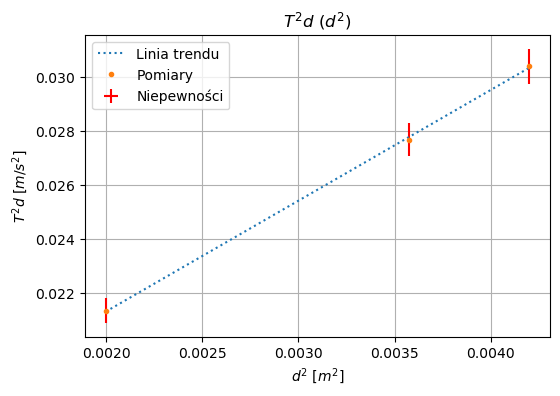

9.663321881336222 0.16598806192873972
0.0038328721849829176 6.915604564600726e-05


In [9]:
def draw():
    plt.rcParams['figure.dpi'] = 100
    x = df1['d']**2
    y = df1['T']**2 * df1['d']
    xerr = np.sqrt((2*df1['d'])**2 * df1['ud']**2)
    yerr = np.sqrt((2*df1['T'] * df1['d'])**2 * df1['uT']**2 + (df1['T']**2)**2 * df1['ud']**2)
    p, V = np.polyfit(x, y, 1, cov=True)

    
    plt.plot(x, p[0]*x+p[1],':',label='Linia trendu')
    #plt.plot(x,alpha*x,':',label='Linia trendu')
    #plt.text(0.015, 4.25, '$y={:.5f}x+{:.5f}$'.format(alpha,b))
    plt.plot(x,y,'.',label="Pomiary")
    plt.xlabel('$d^2\ [m^2]$')
    plt.ylabel('$T^2d\ [m/s^2]$')
    plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr,fmt='none',color='red',label="Niepewności")
    plt.grid(which='both',axis='both')
    plt.legend()
    plt.title("$T^2d\ (d^2)$")
    plt.savefig("T2_d.png",dpi=600)
    plt.show()
    return p, V

p, V = draw()

g = 4 * const.pi**2 / p[0]
ug = np.sqrt( (-4 * const.pi**2 / p[0]**2)**2 * V[0][0])

I0 = p[1] * m * const.g / (4 * const.pi**2)
uI0 = np.sqrt((p[1] * const.g / (4 * const.pi**2))**2 * um**2 + (m * const.g / (4 * const.pi**2))**2 * V[1][1])

g
I0
print(g,ug)
print(I0, uI0)